# Understanding Prior Networks and Regression Prior Networks
   ### A Practical and Mathematical Guide to Uncertainty Modeling in Deep Learning

##  1. Introduction

Deep learning models are powerful, but standard neural networks cannot express uncertainty about their predictions. In many applications—such as self-driving cars, medical diagnosis, or other safety-critical systems—it is important to know *how confident* a model is in its output.

Traditionally, **neural network ensembles** are used to estimate uncertainty because they capture both:
- **Data uncertainty (aleatoric uncertainty)** → noise inherent in the data  
- **Knowledge uncertainty (epistemic uncertainty)** → model ignorance, OOD inputs  

However, ensembles are **computationally expensive**, because they require running **many neural networks** at inference time. This makes them impractical for real-world systems that need fast predictions.

To solve this, **Prior Networks** were introduced for **classification tasks**. Instead of predicting class probabilities directly (e.g., through a softmax layer), Prior Networks predict the parameters of a **Dirichlet distribution**, allowing a single model to mimic the uncertainty behavior of an entire ensemble.

This idea was later extended to continuous outputs in **Regression Prior Networks (Malinin et al., 2020)**, which use a **Normal–Wishart prior** and produce **Student-t predictive distributions**. These models allow single-network uncertainty estimation for regression problems.

In this notebook, we will:

- Understand why ensembles provide strong uncertainty  
- Explain why ensembles are expensive at inference  
- Show how Prior Networks solve the ensemble cost problem  
- Explain how **classification Prior Networks** work (Dirichlet priors)  
- Explain how **Regression Prior Networks** work (Normal–Wishart priors → Student-t output)  
- Show how this relates to **Evidential Deep Learning (Sensoy et al., 2018)**  


## 2. Ensembles and Why They Matter

Deep learning ensembles combine several independently trained models:


$ f^{(1)}, f^{(2)}, \dots, f^{(M)}$ 


Ensembles capture two types of uncertainty:

### 🔹 Data Uncertainty (Aleatoric)
Noise in the data.

### 🔹 Knowledge Uncertainty (Epistemic)
Model uncertainty due to lack of knowledge.

Ensembles are powerful but computationally expensive:

- $M×$ compute  
- $M×$ memory  
- $M×$ inference time  

 but we need something cheaper that still captures uncertainty.

This leads to **Prior Networks**.


## 3. Prior Networks for Classification (Dirichlet Prior Networks)

Prior Networks were first introduced for **classification tasks** (Malinin & Gales, 2019).
Instead of predicting class probabilities directly using softmax, a Prior Network predicts the
parameters of a **Dirichlet distribution**:

$ 
p(\mathbf{p} \mid x) = \mathrm{Dirichlet}(\alpha_1(x), \dots , \alpha_K(x))
$ 

Where:
- Each $ \alpha_k\ $  represents **evidence** for class \(k\).
- High $ \alpha_k\ $  → strong belief → low epistemic uncertainty  
- Low $ \alpha_k\ $  → weak belief → high epistemic uncertainty  

## 🔹 Why Dirichlet?

The Dirichlet distribution is the **conjugate prior** of the categorical distribution.  
This makes it ideal for classification because it models *distributions over class probabilities*.

## 🔹 Predictive Distribution

Instead of directly predicting $p(y \mid x)$, a Prior Network computes:


$ p(y \mid x) = \int p(y \mid \mathbf{p}) \, p(\mathbf{p} \mid x) \, d\mathbf{p}$ 


This allows clean decomposition into:

### ✔ Total uncertainty  
### ✔ Data (aleatoric) uncertainty  
### ✔ Knowledge (epistemic) uncertainty  

## 🔹 Why is this useful?

➡ A single Prior Network can capture **ensemble-like uncertainty**  
➡ Without needing to run an ensemble at inference time  
➡ Saving compute, memory, and latency.


## 4. Transition From Classification to Regression Prior Networks

Dirichlet Prior Networks work extremely well for classification.

BUT

Regression tasks deal with **continuous outputs**, not discrete class probabilities.

So we need:
- A predictive likelihood: **Normal distribution**
- A prior over Normal parameters (mean + precision)

The correct conjugate prior to a Normal distribution is:

➡ **Normal–Wishart distribution**

This leads directly to:

✔ Regression Prior Networks  
✔ Continuous uncertainty modeling  
✔ Student-t predictive distributions  


## 5. Regression Prior Networks (RPNs)

Regression Prior Networks generalize Prior Networks to **continuous-valued predictions**.

### Step 1 — Use a Normal likelihood

A normal regression model predicts:


$p(y \mid x, \mu, \Lambda) = \mathcal{N}(y \mid \mu, \Lambda^{-1})$


Where:
- $ \mu\ $ = predicted mean  
- $ \Lambda\ $ = precision (inverse covariance matrix)  

### Step 2 — Predict a *distribution* over (\mu, \Lambda)

RPNs do NOT predict a single Normal distribution.  
They predict a **Normal–Wishart prior** over the regression parameters:


$(\mu, \Lambda) \sim \mathrm{NormalWishart}(m, L, \kappa, \nu)$

Where:
- $ m $ = prior mean  
- $ L $ = prior precision structure  
- $ \kappa\ $ = belief strength in $ m $  
- $ \nu\ $ = belief strength in $ L $ 

These control epistemic uncertainty.

### Step 3 — Predictive distribution is a Student-t

When integrating out the uncertainty in $ \mu\ $ and $ \Lambda\ $:

$
p(y \mid x) = \mathrm{Student\text{-}t}(y)
$

Why Student-t?
- Because **Normal likelihood + Normal–Wishart prior = Student-t**.
- Student-t has **heavier tails**, which naturally capture uncertainty.

### Benefits of Student-t

✔ Detects OOD inputs  
✔ Captures both aleatoric + epistemic uncertainty  
✔ More robust than a Gaussian  

## 5.1 The Student-t Distribution

When a Regression Prior Network predicts uncertainty, it does not produce a simple Normal
distribution. Instead, it produces a **Student-t distribution**, which is the result of:

$
\text{Normal likelihood} + \text{Normal–Wishart prior} \;\Rightarrow\; \text{Student-t predictive distribution}
$

This is a fundamental Bayesian identity.

---

### 🔹 Why Student-t instead of Normal?

A Normal distribution assumes:
- fixed variance  
- no epistemic uncertainty  

But in real-world scenarios:
- the mean (μ) is uncertain  
- the variance (σ²) is uncertain  
- the model is uncertain about its parameters  

A Student-t distribution has *heavier tails*, meaning:

- more probability in extreme values  
- it naturally expresses **model uncertainty**  
- it becomes wider when the model lacks knowledge  
- it shrinks toward a Normal distribution when confident  

---

### 🔹 Shape of a Student-t distribution

The parameter **ν** (nu, degrees of freedom) controls how heavy the tails are:

- Small ν → *very heavy tails* (uncertain)
- Medium ν → *moderately heavy* (some uncertainty)
- Large ν → approaches a Normal distribution (confident)

Examples:
- ν = 1 → Cauchy distribution (extremely heavy-tailed)  
- ν = 3 → high uncertainty  
- ν = 30 → almost Normal  
- ν → ∞ → Normal distribution  

---

### 🔹 Why is this important for RPNs?

Because Student-t naturally captures the behavior of an ensemble:

- if models disagree → tail gets heavier → epistemic uncertainty rises  
- if data is noisy → variance stays large → aleatoric uncertainty  
- if model is confident → distribution becomes narrow & Gaussian  

Thus, Student-t is the *perfect* predictive distribution for expressing uncertainty in regression tasks.



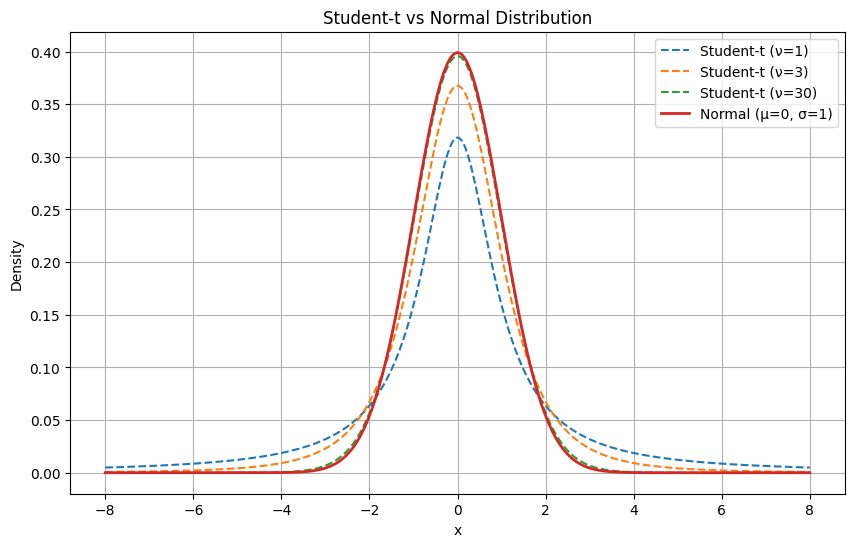

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, t

# Values to plot
x = np.linspace(-8, 8, 400)

# Different degrees of freedom
t1 = t.pdf(x, df=1)  # very heavy-tailed
t3 = t.pdf(x, df=3)  # moderate uncertainty
t30 = t.pdf(x, df=30)  # almost normal

normal = norm.pdf(x, 0, 1)

plt.figure(figsize=(10, 6))
plt.plot(x, t1, label="Student-t (v=1)", linestyle="--")
plt.plot(x, t3, label="Student-t (v=3)", linestyle="--")
plt.plot(x, t30, label="Student-t (v=30)", linestyle="--")
plt.plot(x, normal, label="Normal (μ=0, o=1)", linewidth=2)

plt.title("Student-t vs Normal Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## 6. Ensemble Distribution Distillation (EnD²)

Neural network ensembles are great for uncertainty, but expensive.
RPNs support **Ensemble Distribution Distillation (EnD²)** to learn ensemble behavior
without needing to run an ensemble at inference.

### How EnD² works

1. Train an ensemble of regression models  
2. Collect their predicted $ (\muᵐ, \Lambdaᵐ)$  values  
3. Treat these values as samples from an empirical distribution  
4. Train ONE Regression Prior Network to *match this distribution*  
5. Use **temperature annealing**:
   - High T → learn the ensemble mean  
   - Low T → learn full ensemble diversity (variance, disagreement)  

### Why this is important?

✔ The RPN learns:
- Ensemble mean  
- Ensemble variance  
- Ensemble disagreement  

➤ But runs as **one single model** at inference time.  


## 7. Comparison: Regression Prior Networks vs Evidential Deep Learning

| Aspect | Regression Prior Networks (RPN) | Evidential Deep Learning (EDL) |
|--------|----------------------------------|--------------------------------|
| Task Type | Regression | Classification |
| Prior Distribution | Normal–Wishart | Dirichlet |
| Predictive Output | Student-t | Categorical |
| Evidence Concept | (m, L, κ, ν) | α (Dirichlet evidence) |
| Uncertainty | Aleatoric + Epistemic | Aleatoric + Epistemic |
| Independence | No sampling needed | No sampling needed |
| Ensemble Behavior | Explicitly distillable (EnD²) | Implicit via evidence |
| Conjugate Structure | Strong Bayesian foundation | Subjective logic |

### Key insights

- Both aim to model **uncertainty** realistically.  
- Both use **prior distributions** over predictive parameters.  
- RPN extends this idea to **continuous regression outputs**.  
- EDL introduced "evidence" concepts that inspired RPN.  


## 8. Conclusion

- Ensembles give excellent uncertainty estimates but are computationally expensive.  
- Prior Networks solve this problem by learning a *prior distribution* over predictions.  
- Classification Prior Networks use the **Dirichlet distribution**.  
- Regression Prior Networks generalize this using the **Normal–Wishart prior**.  
- The resulting predictive distribution is a **Student-t**, ideal for uncertainty modeling.  
- With **EnD²**, RPNs can learn the full behavior of ensembles with only one model.  
- These ideas are closely related to Evidential Deep Learning but adapted for regression.  

This hereby concludes the theoretical explanation of Regression Prior Networks.
